In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline
from matplotlib.ticker import LogLocator, LogFormatter

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2kg/s
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

#Atomic Constants in SI units
me = 9.1093837e-31 # mass of an electron
mH = 1.673557695220333e-27 # mass of Hydrogen
mT = 5.0082676661837955e-27 # mass of Tritium
mue = 9.2740100657e-24 #Magnetic moment of an electron J/T
mup = 1.41060679545e-26 #Magnetic moment of a proton J/T
ge = 2.002319 #Electron g-factor

#Hyperfine Constants
gL = 1 #Orbital g-factor
gS = 2 #Electron spin g-factor
L = 0 #Orbital Angular Momentum
S = .5 #Electron spin
I = .5 #Nuclear spin
J = .5 #Total Angular Momentum

#Hydrogen
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
gIH = 5.585694702 # Hydrogen nuclear g-factor
#Tritium
delWT = 1.516701396e9
gIT = 5.95792492 # Tritium nuclear g-factor

#gyromagnetic constants 
gamH=42.577*2*np.pi # In MHz/T
gamT=45.415*2*np.pi # in MHz/T
game=-28024.9*np.pi # in MHz/T

#Important Conversion Factors
Bohr2m = .529177e-10
Dalton2kg = 1.66053906892e-27
Dalton2eV=931.49410372e6
invB2eV = 27.211386245988
J2invB = 2.2937e17
eV2J = 1.602176634e-19
kg2eV = 1.78266192e-36
kg2au = 9.1093837e-31
AT2s = 2.4188843265864e-17

In [3]:
#Important Potentials 
#Most modern Silvera Triplet Potential
def Silvera_Triplet(R):
    x=R*Bohr2m/4.16e-10
    D=1.28
    KToH=315775
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46/KToH*(4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

#Old School Silvera Triplet Potential, used to measure uncertainties 
def Triplet(R): 
    return np.exp(0.09678-1.10173*R-0.03945*R**2)+np.exp(-(10.04/R-1)**2)*(-6.5/R**6-124/R**8-3285/R**10)

#Dipolar Interaction Potential 
def Dipolar(R):
    return mue * J2invB * np.sqrt(4 * np.pi/5 ) / (4*np.pi*R**3) * (2 * mup * J2invB - mue * J2invB)

In [4]:

#As part of the Dipolar Relaxation calculation one must first find the solution to the elastic scattering schrodinger equation
#The solution changes for different Triplet potentials, masses, angular momenta contributions, and relative momenta

#Setting up the Schrodinger Equation
def ddx(y, r, muove, Potential, l, p):#The mass term should be for reduced mass over electron mass
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-p**2 + 2 * muove * Potential(r) + l * (l + 1) / (r**2)) * u
    return [dudr,dvdr]

#Solving the ODE and setting up the normalized state that will be put into the calculation
def Wave_Function(p, l, A, r0, function, muove, version, int_type):
    rhos = np.linspace(r0, A, int(A)*10)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, muove, Silvera_Triplet, l, p)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0] ,rhos[-1]),init,t_eval=rhos,method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/p)**2)
    return State.y[0]/Normalization[-1]

#Now that the states have been effectively defined the actual integral for the dipolar lose rates needs to be constructed. 
def GetIntegral (alphain, betain, alphaout, betaout, mass, A, r0, temp , how_to_int):
    rhos = np.linspace(r0, A, int(A)*10)
    
    P1 = p_of_temp( mass / (2 * kg2au), temp)
    P2 = pprime(P1, alphain, betain, alphaout, betaout, mass / (2 * kg2au))
    
    InState = np.array(Wave_Function(P1, 0, A, r0, ddx, mass / (2 * me), Silvera_Triplet, how_to_int))
    OutState = np.array(Wave_Function(P2, 2, A, r0, ddx, mass / (2 * me), Silvera_Triplet, how_to_int))

    Integrand = interp1d(rhos, InState * OutState / rhos**3, kind = 'linear')


    if A <= 250:
        Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
    else:
        Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
        Integral2 = quad(Integrand,250,rhos[-1])[0]/(P1*P2)

        Integral = Integral1 + Integral2

    return Integral

In [5]:
#We want to see the ratios for both identical momentums and for identical temperatures 
#Therefore a means of determining momentum from temperature is necessary 
#Additionally a method of determining outward going momenta is necessary
def p_of_temp(mu, T):
    return np.sqrt(2 * mu * kb * J2invB * T)
 
def pprime(p, epsa, epsb, epsprimea, epsprimeb, mu):
    E = p**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt( 2 * mu * Eprime)
    return pprime

In [6]:
B = np.logspace(-3,1,30)
def GetHyperFineLevels(pm, mf, delW, mN, gI):
    meeV = me / kg2eV
    muN = mue*meeV/(mN*1e9)
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B)
    Term2 = muN * gI * mf * B

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h / eV2J

def AllHFLevels(delW, mN, gI): #This creates the array of values for each important level
    delEs = []
    for pm in [-1,1]:
        F = I + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

Text(0.5, 0, 'B (T)')

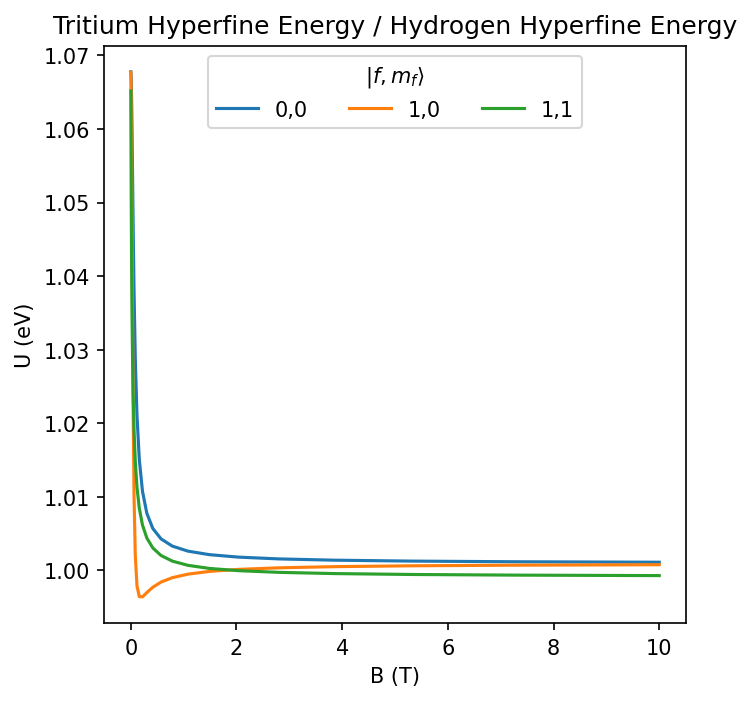

In [7]:
cols = ['DarkRed','DarkBlue','Purple','Black']
plt.figure(figsize=(5,5),dpi=150)
for pm in [-1,1]:
    F = I + pm/2
    for mF in np.arange(0,F+1,1):
        delEH = GetHyperFineLevels(pm,mF,delWH,mH/Dalton2kg,gIH)
        delET = GetHyperFineLevels(pm,mF,delWT,mT/Dalton2kg,gIT)
        plt.plot(B,delET/delEH,label=str(int(F))+","+str(int(mF)))

plt.title("Tritium Hyperfine Energy / Hydrogen Hyperfine Energy")
plt.legend(loc='upper center',ncol=4,title=r'$|f,m_f\rangle$' )
plt.ylabel("U (eV)")
plt.xlabel("B (T)")

In [8]:
HLevels = AllHFLevels(delWH, mH / Dalton2kg, gIH)
TLevels = AllHFLevels(delWT, mT / Dalton2kg, gIT)
letters = ['a', 'c', 'd']

In [9]:
e=symbols('e')
c=symbols('c')
s=symbols('s')
sr2=symbols('sr2')
sr3=symbols('sr3')

In [10]:
def LetterToNumber(letter):
    if(letter=="a"):
        return 0
    elif(letter=="b"):
        return 1
    elif(letter=="c"):
        return 2
    elif(letter=="d"):
        return 3
    else:
        print("invalid letter state, "+str(letter))
        assert(0)

In [11]:
def NumberToLetter(num):
    if(num==0):
        return "a"
    elif(num==1):
        return "b"
    elif(num==2):
        return "c"
    elif(num==3):
        return "d"
    else:
        print("invalid number state, "+str(num))
        assert(0)

In [12]:
def StateToBasis(in1,in2,p=1):
    # convert letter basis to number basis
    if(type(in1)==str):
        in1=LetterToNumber(in1)
    else:
        in1=int(in1)
    if(type(in2)==str):
        in2=LetterToNumber(in2)
    else:
        in2=int(in2)
    #swap so first one is always smaller
    if(in2<in1):
        in1old=in1
        in1=in2
        in2=in1old

    if(in1==0 and in2==0 and p==1):
        return 0
    if(in1==1 and in2==1 and p==1):
        return 1
    if(in1==2 and in2==2 and p==1):
        return 2
    if(in1==3 and in2==3 and p==1):
        return 3
    if(in1==0 and in2==1 and p==1):
        return 4
    if(in1==0 and in2==1 and p==-1):
        return 5
    if(in1==0 and in2==2 and p==1):
        return 6
    if(in1==0 and in2==2 and p==-1):
        return 7
    if(in1==0 and in2==3 and p==1):
        return 8
    if(in1==0 and in2==3 and p==-1):
        return 9
    if(in1==1 and in2==2 and p==1):
        return 10
    if(in1==1 and in2==2 and p==-1):
        return 11
    if(in1==1 and in2==3 and p==1):
        return 12
    if(in1==1 and in2==3 and p==-1):
        return 13
    if(in1==2 and in2==3 and p==1):
        return 14
    if(in1==2 and in2==3 and p==-1):
        return 15

In [13]:
SingletProj=[
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1/2,0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,0,  0,  0,  0,  0, 1/2, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ]

TripletProj=[
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 0.5,0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 0.5, 0,  0,  0,  0,  0, 0.5, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]
                ]


Sig2m2proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])


Sig2p2proj=-1/2*np.array([
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])
#sr2=np.sqrt(2)
Sig2p1proj=-1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0, -1/sr2,0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, -1/2,  0,  0,  0,  0,  0, -1/2,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/(2*sr2),0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/2, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/2],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
                ])

Sig2m1proj=1/2*np.array([
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/sr2, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,1/sr2, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,-1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [-1/(2*sr2), 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,-1/(2*sr2),  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0, 1/2, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/2,  0,  0,  0,  0,  0,  1/2,  0,  0]
                ])

Sig20proj=-np.sqrt(3/2)*np.array([
    [1/6,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,1/6,  0,  0,  0,  0,  0,1/6,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,-1/3, 0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0, 1/6, 0,  0,  0,  0,  0, 1/6, 0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 1/6, 0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,1/6]
                ])

In [14]:
Rotator=[
    [1,  0,  0,  0,  0,  0, 2*e, 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0, -2*e,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -e,  0,  0,  0,  0],
    [-e, 0,  e,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0, -e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  e,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -e, 0,  0,  0,  0,  1]
                ]


Rotator=np.array([
    [c*c,0,  s*s,0,  0,  0,sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [s*s,0,  c*c,0,  0,  0,-sr2*s*c,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0, -s,  0,  0,  0,  0],
    [-sr2*s*c,0,sr2*s*c, 0,  0,  0,  c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  c*c-s*s,0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0,  s],
    [0,  0,  0,  0, -s,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  s,  0,  0,  0,  0,  0,  c,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  -s, 0,  0,  0,  0,  c,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  -s, 0,  0,  0,  0,  c]
                ])

Sigmas={-2:Sig2m2proj,-1:Sig2m1proj,0:Sig20proj,1:Sig2p1proj,2:Sig2p2proj}

In [15]:
def TransformMatrix(M,R):
    return(np.matmul(np.transpose(R),np.matmul(M,R)))

def RotateByEpsilon(M,eps):
    M1=TransformMatrix(M,Rotator)
    return(EvaluateWithEpsilon(M,eps))


def EvaluateWithEpsilon(M,eps):
    return np.array([(i+0*e).subs(e,eps) for i in M.flatten()]).reshape(M.shape).astype(float)

In [16]:
def GetElement(M,alpha, beta, p1, alphaprime, betaprime, pprime):
    index1=StateToBasis(alpha,beta,p1)
    index2=StateToBasis(alphaprime,betaprime,pprime)
    return(M[index1,index2])

In [17]:
Rets={}
for m in Sigmas.keys():
    SigMatrix=Sigmas[m]
    Rets[m]=TransformMatrix(np.matmul(np.matmul(TripletProj,SigMatrix),TripletProj),Rotator)

In [18]:
def Theta(a,B,game,gamN):
    return(0.5*np.arctan(a/(2*B*(game+gamN))))

In [19]:
NormDiff = 1
letters = ['a', 'b', 'c', 'd']
a1 = 'd'
a2 = 'd'

HaaSpins = []
HacSpins = []
HadSpins = []
HccSpins = []
HcdSpins = []
for a3 in letters: 
    for a4 in letters:
        line = []  
        for b in B:
            theta = Theta(2 * delWH * 1e-6, b, gamH, game)  
            value = 0
            for m in Rets.keys():
                El = (NormDiff * GetElement(Rets[m], a1, a2, 1, a3, a4, 1)) ** 2
                try:
                    value += El.subs(sr2, np.sqrt(2)) \
                              .subs(sr3, np.sqrt(3)) \
                              .subs(c, np.cos(theta)) \
                              .subs(s, np.sin(theta))
                except:
                    value += 0
            line.append(value)
        if a4 == 'a' and a3 == 'a':
            HaaSpins = line  
        elif a4 == 'c' and a3 == 'a':
            HacSpins = line
        elif a4 == 'd'  and a3 == 'a':
            HadSpins = line
        elif a3 == 'c' and a4 == 'c':
            HccSpins = line
        elif a3 == 'c' and a4 == 'd':
            HcdSpins = line
            
HaaSpins = np.array(HaaSpins)
HacSpins = np.array(HacSpins)
HadSpins = np.array(HadSpins)
HccSpins = np.array(HccSpins)
HcdSpins = np.array(HcdSpins)

TaaSpins = []
TacSpins = []
TadSpins = []
TccSpins = []
TcdSpins = []
for a3 in letters:
    for a4 in letters:
        line = []  
        for b in B:
            theta = Theta(2 * delWT * 1e-6, b, gamT, game)  
            value = 0
            for m in Rets.keys():
                El = (NormDiff * GetElement(Rets[m], a1, a2, 1, a3, a4, 1)) ** 2
                try:
                    value += El.subs(sr2, np.sqrt(2)) \
                              .subs(sr3, np.sqrt(3)) \
                              .subs(c, np.cos(theta)) \
                              .subs(s, np.sin(theta))
                except:
                    value += 0
            line.append(value)
        if a4 == 'a' and a3 == 'a':
            TaaSpins = line  
        elif a4 == 'c' and a3 == 'a':
            TacSpins = line
        elif a4 == 'd'  and a3 == 'a':
            TadSpins = line
        elif a3 == 'c' and a4 == 'c':
            TccSpins = line
        elif a3 == 'c' and a4 == 'd':
            TcdSpins = line
TaaSpins = np.array(TaaSpins)
TacSpins = np.array(TacSpins)
TadSpins = np.array(TadSpins)
TccSpins = np.array(TccSpins)
TcdSpins = np.array(TcdSpins)

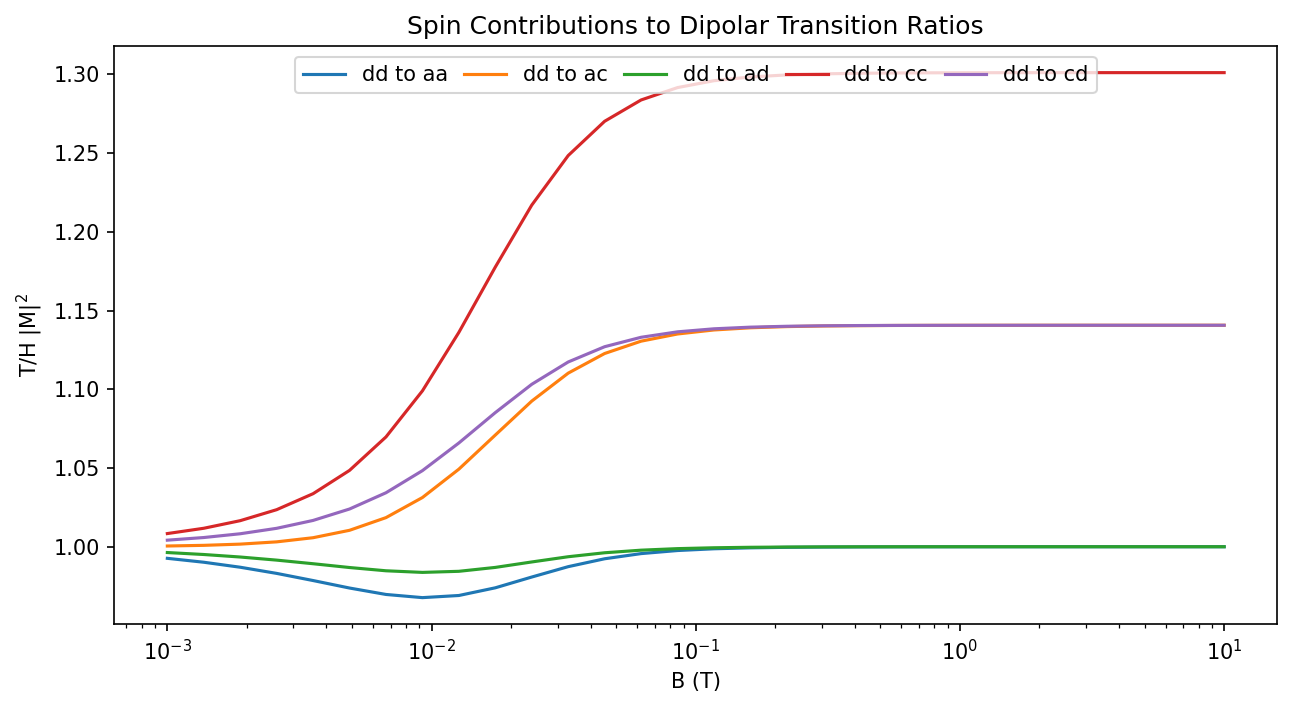

In [20]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(B, TaaSpins/HaaSpins, label="dd to aa")
plt.plot(B, TacSpins/HacSpins, label="dd to ac")
plt.plot(B, TadSpins/HadSpins, label="dd to ad")
plt.plot(B, TccSpins/HccSpins, label="dd to cc")
plt.plot(B, TcdSpins/HcdSpins, label="dd to cd")
plt.semilogx()
plt.xlabel("B (T)")
plt.ylabel("T/H |M|$^2$")
plt.title("Spin Contributions to Dipolar Transition Ratios")
plt.legend(loc='upper center', fontsize=10, ncol=14, columnspacing=0.8)
plt.show()

In [21]:
HaaSpatials = []
HacSpatials = []
HadSpatials = []
HccSpatials = []
HcdSpatials = []
TaaSpatials = []
TacSpatials = []
TadSpatials = []
TccSpatials = []
TcdSpatials = []

i = 0 
for b in B:
    aH = HLevels['a'][i] / invB2eV
    cH = HLevels['c'][i] / invB2eV
    dH = HLevels['d'][i] / invB2eV
    
    aT = TLevels['a'][i] / invB2eV
    cT = TLevels['c'][i] / invB2eV
    dT = TLevels['d'][i] / invB2eV

    r0 = 1e-3
    temp = 1e-3
    intlimit = 2000

    PH = p_of_temp( mH / (2 * kg2au) , temp)
    PT = p_of_temp( mT / (2 * kg2au) , temp)

    PoutHaa = pprime(PH, dH, dH, aH, aH, mH / (2 * kg2au))
    PoutHac = pprime(PH, dH, dH, aH, cH, mH / (2 * kg2au))
    PoutHad = pprime(PH, dH, dH, aH, dH, mH / (2 * kg2au))
    PoutHcc = pprime(PH, dH, dH, cH, cH, mH / (2 * kg2au))
    PoutHcd = pprime(PH, dH, dH, cH, dH, mH / (2 * kg2au))
    
    PoutTaa = pprime(PT, dT, dT, aT, aT, mT / (2 * kg2au))
    PoutTac = pprime(PT, dT, dT, aT, cT, mT / (2 * kg2au))
    PoutTad = pprime(PT, dT, dT, aT, dT, mT / (2 * kg2au))
    PoutTcc = pprime(PT, dT, dT, cT, cT, mT / (2 * kg2au))
    PoutTcd = pprime(PT, dT, dT, cT, dT, mT / (2 * kg2au))  

    IntegralHac = GetIntegral(dH, dH, aH, cH, mH, intlimit, r0, temp, 'DOP853')
    IntegralHad = GetIntegral(dH, dH, aH, dH, mH, intlimit, r0, temp, 'DOP853')
    IntegralHcc = GetIntegral(dH, dH, cH, cH, mH, intlimit, r0, temp, 'DOP853')
    IntegralHcd = GetIntegral(dH, dH, cH, dH, mH, intlimit, r0, temp, 'DOP853')

    IntegralTac = GetIntegral(dT, dT, aT, cT, mT, intlimit, r0, temp, 'DOP853')
    IntegralTad = GetIntegral(dT, dT, aT, dT, mT, intlimit, r0, temp, 'DOP853')
    IntegralTcc = GetIntegral(dT, dT, cT, cT, mT, intlimit, r0, temp, 'DOP853')
    IntegralTcd = GetIntegral(dT, dT, cT, dT, mT, intlimit, r0, temp, 'DOP853')
    
    if b <= 8.5:
        IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'DOP853')
        IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'DOP853')
        
    else:
        IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'RK45')
        IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'RK45')

    HaaSpatials.append(PoutHaa * mH / (2 * kg2au) * IntegralHaa**2)
    HacSpatials.append(PoutHac * mH / (2 * kg2au) * IntegralHac**2)
    HadSpatials.append(PoutHad * mH / (2 * kg2au) * IntegralHad**2)
    HccSpatials.append(PoutHcc * mH / (2 * kg2au) * IntegralHcc**2)
    HcdSpatials.append(PoutHcd * mH / (2 * kg2au) * IntegralHcd**2)

    TaaSpatials.append(PoutTaa * mT / (2 * kg2au) * IntegralTaa**2)
    TacSpatials.append(PoutTac * mT / (2 * kg2au) * IntegralTac**2)
    TadSpatials.append(PoutTad * mT / (2 * kg2au) * IntegralTad**2)
    TccSpatials.append(PoutTcc * mT / (2 * kg2au) * IntegralTcc**2)
    TcdSpatials.append(PoutTcd * mT / (2 * kg2au) * IntegralTcd**2)

    i = i + 1   

HaaSpatials = np.array(HaaSpatials) 
HacSpatials = np.array(HacSpatials) 
HadSpatials = np.array(HadSpatials) 
HccSpatials = np.array(HccSpatials) 
HcdSpatials = np.array(HcdSpatials) 
TaaSpatials = np.array(TaaSpatials) 
TacSpatials = np.array(TacSpatials) 
TadSpatials = np.array(TadSpatials) 
TccSpatials = np.array(TccSpatials) 
TcdSpatials = np.array(TcdSpatials) 

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:39: IntegrationWarning: The m

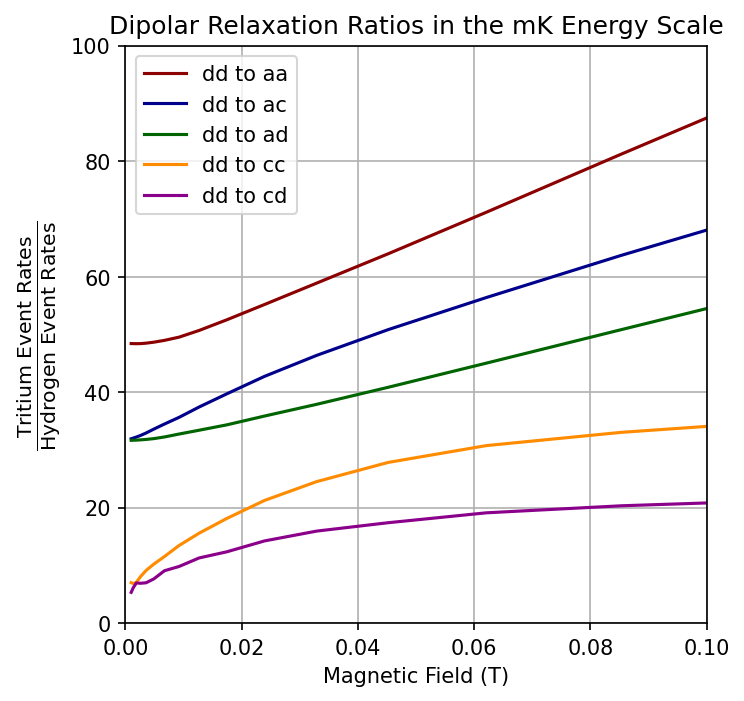

In [23]:
plt.figure(figsize=(5, 5), dpi = 150)

plt.plot(B, TaaSpatials * TaaSpins/ (HaaSpatials * HaaSpins), label = "dd to aa", color = "DarkRed")
plt.plot(B, TacSpatials * TacSpins / (HacSpatials * HacSpins), label = "dd to ac", color = "DarkBlue")
plt.plot(B, TadSpatials * TadSpins / (HadSpatials * HadSpins), label = "dd to ad", color = "DarkGreen")
plt.plot(B, TccSpatials * TccSpins / (HccSpatials * HccSpins), label = "dd to cc", color = "DarkOrange")
plt.plot(B, TcdSpatials * TcdSpins / (HcdSpatials * HcdSpins), label = "dd to cd", color = "DarkMagenta")

plt.xlabel("Magnetic Field (T)")
plt.xlim(0,.1)
plt.ylabel(r'$\frac{\text{Tritium Event Rates}}{\text{Hydrogen Event Rates}}$', fontsize=14)
plt.ylim(0,100)
plt.title("Dipolar Relaxation Ratios in the mK Energy Scale")
plt.grid(True)
plt.legend()
plt.show()

In [24]:
#For the absolute rates all that is missing is the constants. 
#EQ 34) 4pi^3 hbar^2 mu p out |T|^2, mu and p out are already included as they are important to the ratios. 
#EQ 23) mu0 mue / 4pi (4pi/5)^.5 (2mup - mue) * 3-J symbol defines the constant associated with T 

#Determinings the 3-J symbol contributions
l1 = 0 #incoming angular momentum is always 0
l2 = 2 #outward going angular momentum is always 2
l3_range = range (0,3) # assosciated with the total possible sum of these being  0 , 1, 2
m1 = 0 # since l1 = 0 and |m1| <= l1
for l3 in l3_range:
    for m3 in range (-l3, l3+1): #by definition of the projection of these spins
        m2 = m1 - m3 #conservation 
        spherical_jazz = gaunt (l1, l2, l3, -m1, m2, m3) #the minus sign comes from needing to take a complex congujate 
#during the derivation
        if spherical_jazz != 0:
            print(f"l1 = {l1}, l3 = {l3}, m1 = {m1}, m3 = {m3}")
            print(spherical_jazz)

l1 = 0, l3 = 2, m1 = 0, m3 = -2
1/(2*sqrt(pi))
l1 = 0, l3 = 2, m1 = 0, m3 = -1
-1/(2*sqrt(pi))
l1 = 0, l3 = 2, m1 = 0, m3 = 0
1/(2*sqrt(pi))
l1 = 0, l3 = 2, m1 = 0, m3 = 1
-1/(2*sqrt(pi))
l1 = 0, l3 = 2, m1 = 0, m3 = 2
1/(2*sqrt(pi))


In [25]:
prefactor = 80 * np.pi**5 * (4 * np.pi / 137**2)**2 * (1/2)**4 
print (prefactor)

0.000685893721139763


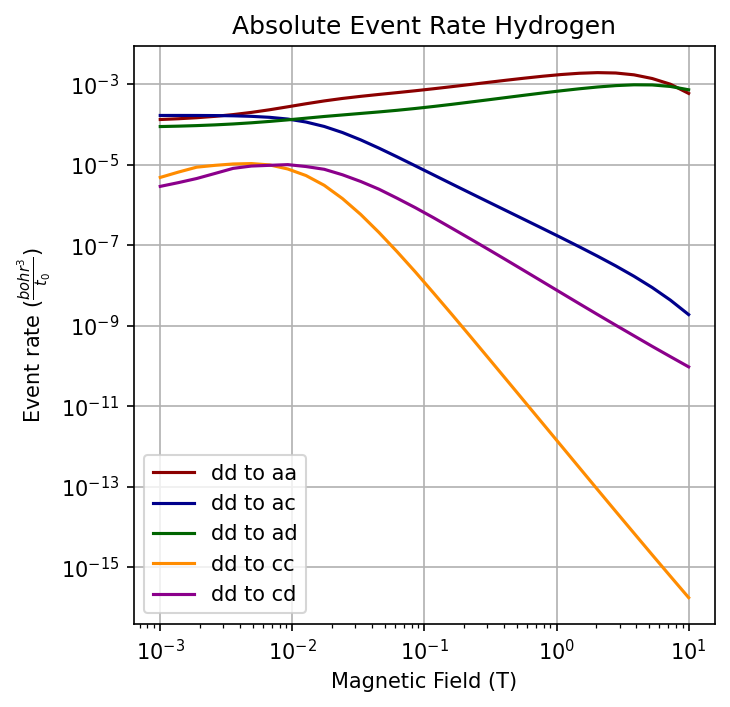

In [27]:
plt.figure(figsize=(5, 5), dpi = 150)

plt.loglog(B, prefactor * HaaSpatials * HaaSpins, label = "dd to aa", color = "DarkRed")
plt.loglog(B, prefactor * HacSpatials * HacSpins, label = "dd to ac", color = "DarkBlue")
plt.loglog(B, prefactor * HadSpatials * HadSpins, label = "dd to ad", color = "DarkGreen")
plt.loglog(B, prefactor * HccSpatials * HccSpins, label = "dd to cc", color = "DarkOrange")
plt.loglog(B, prefactor * HcdSpatials * HcdSpins, label = "dd to cd", color = "DarkMagenta")

plt.xlabel("Magnetic Field (T)")
plt.ylabel(r'Event rate ($\frac{bohr^3}{t_0}$)')
plt.title("Absolute Event Rate Hydrogen")
plt.grid(True)
plt.legend()
plt.show()

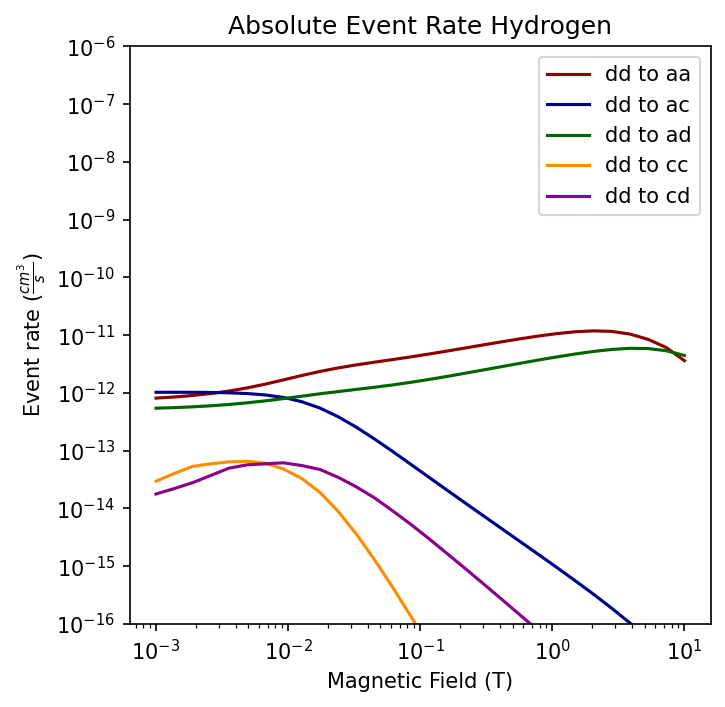

In [28]:
plt.figure(figsize=(5, 5), dpi = 150)

plt.loglog(B, prefactor * HaaSpatials * HaaSpins * Bohr2m**3 * 1e6 / AT2s, label = "dd to aa", color = "DarkRed")
plt.loglog(B, prefactor * HacSpatials * HacSpins * Bohr2m**3 * 1e6 / AT2s, label = "dd to ac", color = "DarkBlue")
plt.loglog(B, prefactor * HadSpatials * HadSpins * Bohr2m**3 * 1e6 / AT2s, label = "dd to ad", color = "DarkGreen")
plt.loglog(B, prefactor * HccSpatials * HccSpins * Bohr2m**3 * 1e6 / AT2s, label = "dd to cc", color = "DarkOrange")
plt.loglog(B, prefactor * HcdSpatials * HcdSpins * Bohr2m**3 * 1e6 / AT2s, label = "dd to cd", color = "DarkMagenta")

plt.xlabel("Magnetic Field (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.title("Absolute Event Rate Hydrogen")

# Fixing the y-axis limits issue
plt.ylim(1e-16, 1e-6)  # Ensure limits are set first


ax = plt.gca()

y_ticks = [1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"$10^{{{int(np.log10(tick))}}}$" for tick in y_ticks], fontsize=10)

plt.legend()
plt.show()

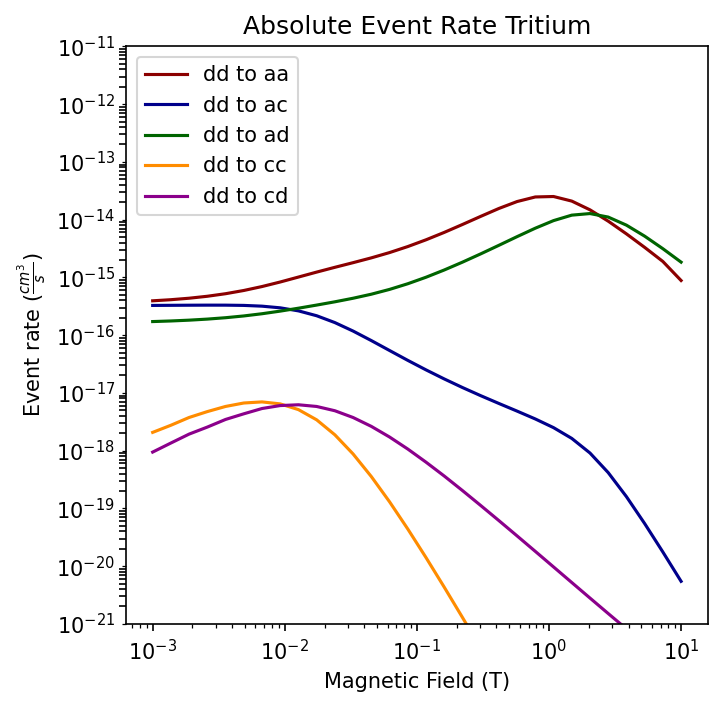

In [29]:
plt.figure(figsize=(5, 5), dpi = 150)

plt.loglog(B, prefactor * TaaSpatials * TaaSpins * Bohr2m**3 * 1e1 / AT2s, label = "dd to aa", color = "DarkRed")
plt.loglog(B, prefactor * TacSpatials * TacSpins * Bohr2m**3 * 1e1 / AT2s, label = "dd to ac", color = "DarkBlue")
plt.loglog(B, prefactor * TadSpatials * TadSpins * Bohr2m**3 * 1e1 / AT2s, label = "dd to ad", color = "DarkGreen")
plt.loglog(B, prefactor * TccSpatials * TccSpins * Bohr2m**3 * 1e1 / AT2s, label = "dd to cc", color = "DarkOrange")
plt.loglog(B, prefactor * TcdSpatials * TcdSpins * Bohr2m**3 * 1e1 / AT2s, label = "dd to cd", color = "DarkMagenta")

plt.xlabel("Magnetic Field (T)")
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21,1e-11)
plt.title("Absolute Event Rate Tritium")

ax = plt.gca()  

ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))
ax.yaxis.set_major_formatter(LogFormatter(base=10.0))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))

plt.legend()
plt.show()

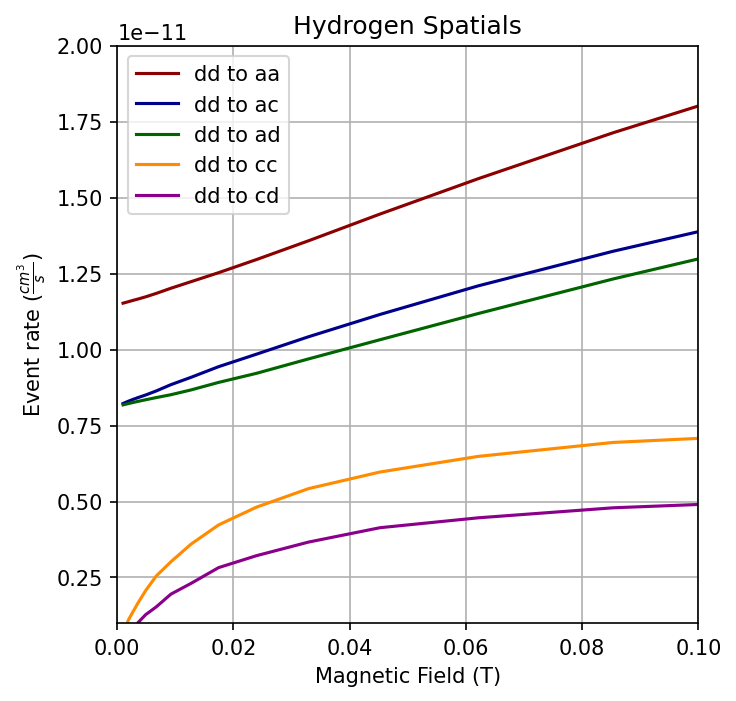

In [37]:
plt.figure(figsize=(5, 5), dpi = 150)

plt.plot(B, prefactor * HaaSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to aa", color = "DarkRed")
plt.plot(B, prefactor * HacSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ac", color = "DarkBlue")
plt.plot(B, prefactor * HadSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ad", color = "DarkGreen")
plt.plot(B, prefactor * HccSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cc", color = "DarkOrange")
plt.plot(B, prefactor * HcdSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cd", color = "DarkMagenta")

plt.xlabel("Magnetic Field (T)")
plt.xlim(0,.1)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-12,2e-11)
plt.title("Hydrogen Spatials")
plt.grid(True)
plt.legend()
plt.show()

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral2 = quad(Integrand,250,rhos[-1])[0]/(P1*P2)


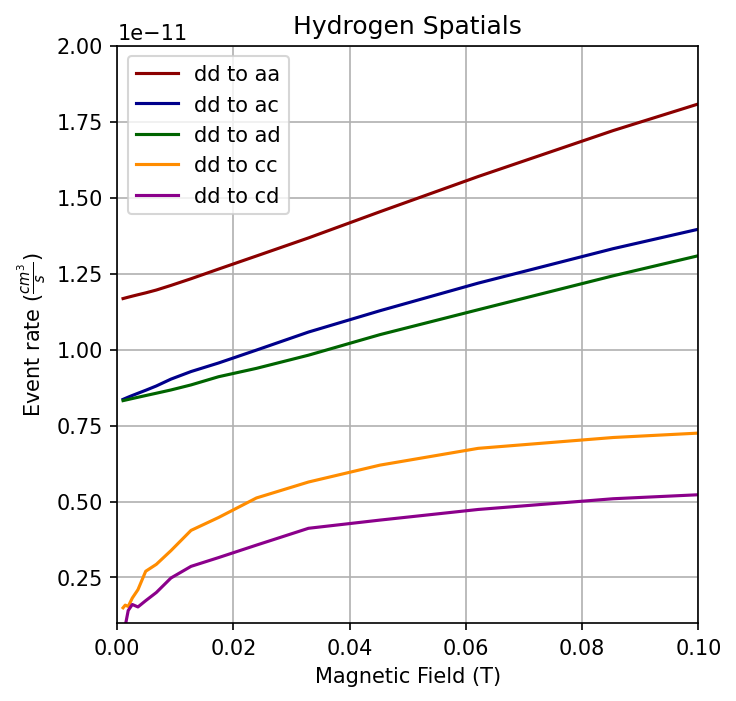

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)


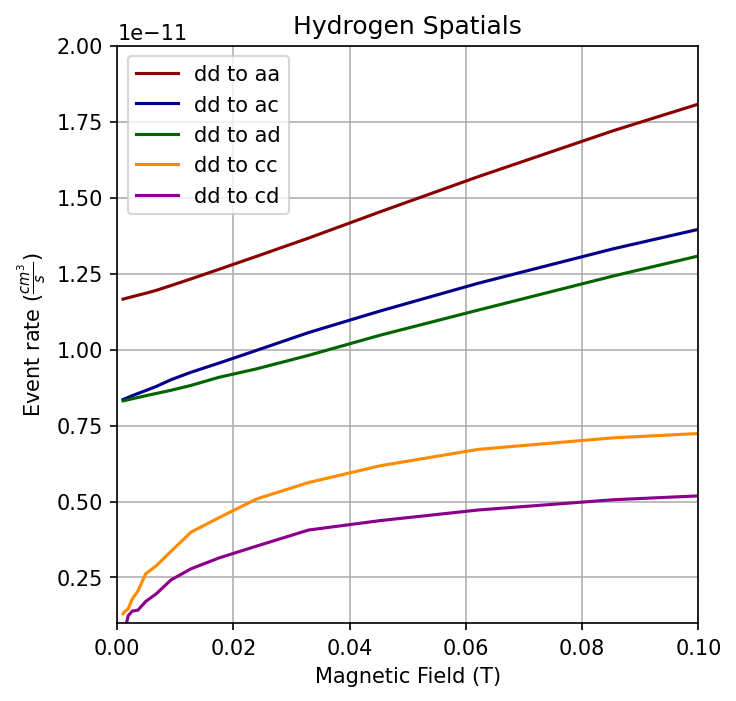

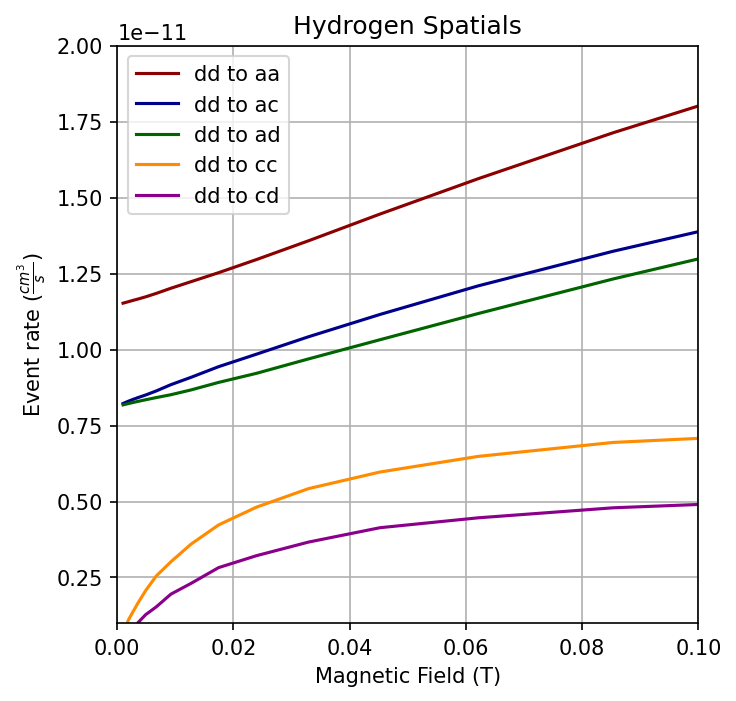

In [41]:
temps = np.logspace(-5,-3,3)
for t in temps:
    HaaSpatials = []
    HacSpatials = []
    HadSpatials = []
    HccSpatials = []
    HcdSpatials = []
    TaaSpatials = []
    TacSpatials = []
    TadSpatials = []
    TccSpatials = []
    TcdSpatials = []
    i = 0 
    for b in B:
        aH = HLevels['a'][i] / invB2eV
        cH = HLevels['c'][i] / invB2eV
        dH = HLevels['d'][i] / invB2eV
    
        aT = TLevels['a'][i] / invB2eV
        cT = TLevels['c'][i] / invB2eV
        dT = TLevels['d'][i] / invB2eV

        r0 = 1e-3
        temp = t
        intlimit = 2000

        PH = p_of_temp( mH / (2 * kg2au) , temp)
        PT = p_of_temp( mT / (2 * kg2au) , temp)

        PoutHaa = pprime(PH, dH, dH, aH, aH, mH / (2 * kg2au))
        PoutHac = pprime(PH, dH, dH, aH, cH, mH / (2 * kg2au))
        PoutHad = pprime(PH, dH, dH, aH, dH, mH / (2 * kg2au))
        PoutHcc = pprime(PH, dH, dH, cH, cH, mH / (2 * kg2au))
        PoutHcd = pprime(PH, dH, dH, cH, dH, mH / (2 * kg2au))
    
        PoutTaa = pprime(PT, dT, dT, aT, aT, mT / (2 * kg2au))
        PoutTac = pprime(PT, dT, dT, aT, cT, mT / (2 * kg2au))
        PoutTad = pprime(PT, dT, dT, aT, dT, mT / (2 * kg2au))
        PoutTcc = pprime(PT, dT, dT, cT, cT, mT / (2 * kg2au))
        PoutTcd = pprime(PT, dT, dT, cT, dT, mT / (2 * kg2au))  

        IntegralHac = GetIntegral(dH, dH, aH, cH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHad = GetIntegral(dH, dH, aH, dH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHcc = GetIntegral(dH, dH, cH, cH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHcd = GetIntegral(dH, dH, cH, dH, mH, intlimit, r0, temp, 'DOP853')

        IntegralTac = GetIntegral(dT, dT, aT, cT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTad = GetIntegral(dT, dT, aT, dT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTcc = GetIntegral(dT, dT, cT, cT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTcd = GetIntegral(dT, dT, cT, dT, mT, intlimit, r0, temp, 'DOP853')
    
        if b <= 8.5:
            IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'DOP853')
            IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'DOP853')
        
        else:
            IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'RK45')
            IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'RK45')
    
        HaaSpatials.append(PoutHaa * mH / (2 * kg2au) * IntegralHaa**2)
        HacSpatials.append(PoutHac * mH / (2 * kg2au) * IntegralHac**2)
        HadSpatials.append(PoutHad * mH / (2 * kg2au) * IntegralHad**2)
        HccSpatials.append(PoutHcc * mH / (2 * kg2au) * IntegralHcc**2)
        HcdSpatials.append(PoutHcd * mH / (2 * kg2au) * IntegralHcd**2)

        TaaSpatials.append(PoutTaa * mT / (2 * kg2au) * IntegralTaa**2)
        TacSpatials.append(PoutTac * mT / (2 * kg2au) * IntegralTac**2)
        TadSpatials.append(PoutTad * mT / (2 * kg2au) * IntegralTad**2)
        TccSpatials.append(PoutTcc * mT / (2 * kg2au) * IntegralTcc**2)
        TcdSpatials.append(PoutTcd * mT / (2 * kg2au) * IntegralTcd**2)

        i = i + 1   
    HaaSpatials = np.array(HaaSpatials) 
    HacSpatials = np.array(HacSpatials) 
    HadSpatials = np.array(HadSpatials) 
    HccSpatials = np.array(HccSpatials) 
    HcdSpatials = np.array(HcdSpatials) 
    TaaSpatials = np.array(TaaSpatials) 
    TacSpatials = np.array(TacSpatials) 
    TadSpatials = np.array(TadSpatials) 
    TccSpatials = np.array(TccSpatials) 
    TcdSpatials = np.array(TcdSpatials) 

    plt.figure(figsize=(5, 5), dpi = 150)
    plt.plot(B, prefactor * HaaSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to aa", color = "DarkRed")
    plt.plot(B, prefactor * HacSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ac", color = "DarkBlue")
    plt.plot(B, prefactor * HadSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ad", color = "DarkGreen")
    plt.plot(B, prefactor * HccSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cc", color = "DarkOrange")
    plt.plot(B, prefactor * HcdSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cd", color = "DarkMagenta")

    plt.xlabel("Magnetic Field (T)")
    plt.xlim(0,.1)
    plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
    plt.ylim(1e-12,2e-11)
    plt.title("Hydrogen Spatials")
    plt.grid(True)
    plt.legend()
    plt.show()

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:38: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)


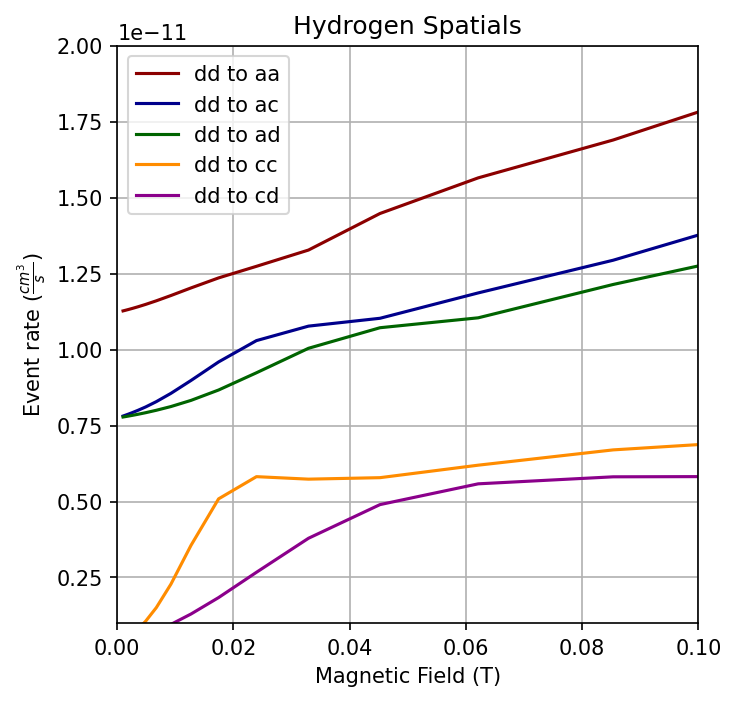

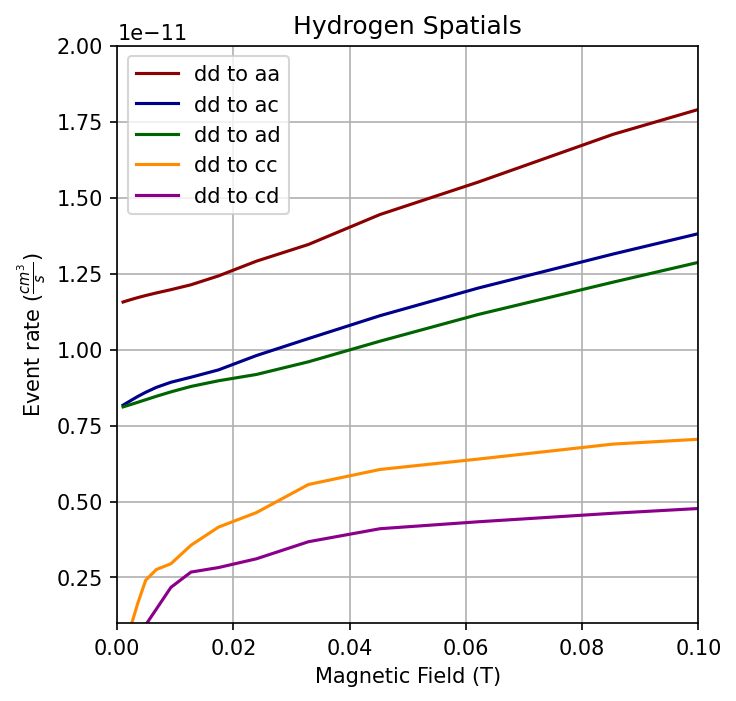

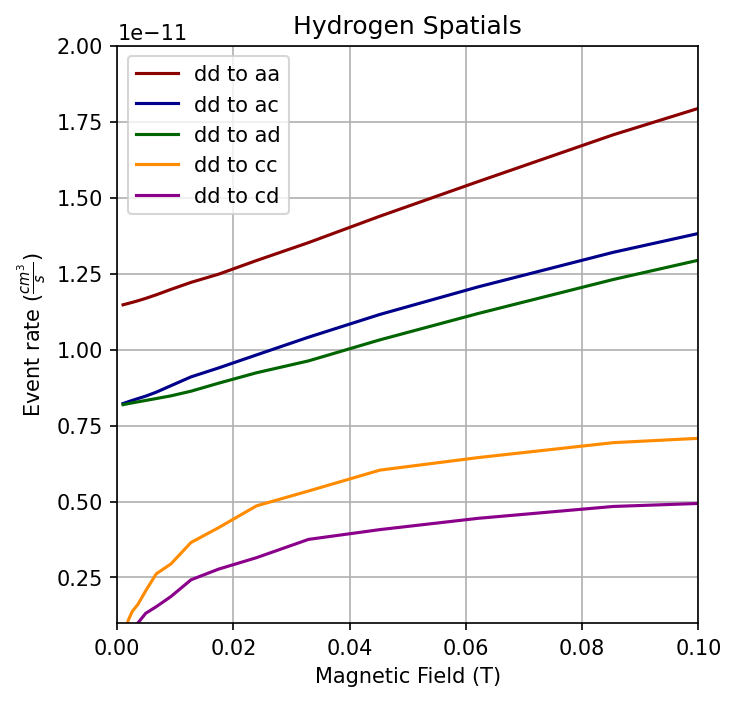

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_7014/1138356206.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral2 = quad(Integrand,250,rhos[-1])[0]/(P1*P2)


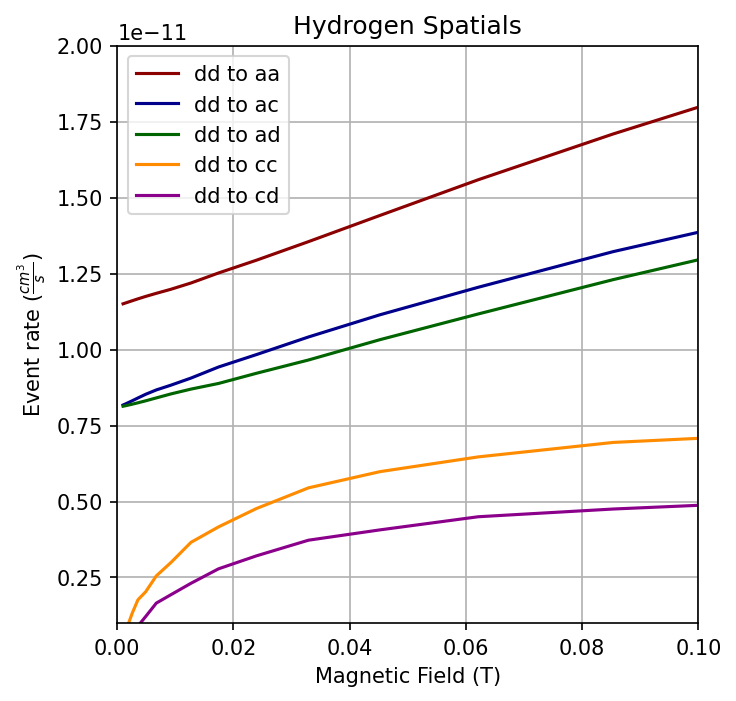

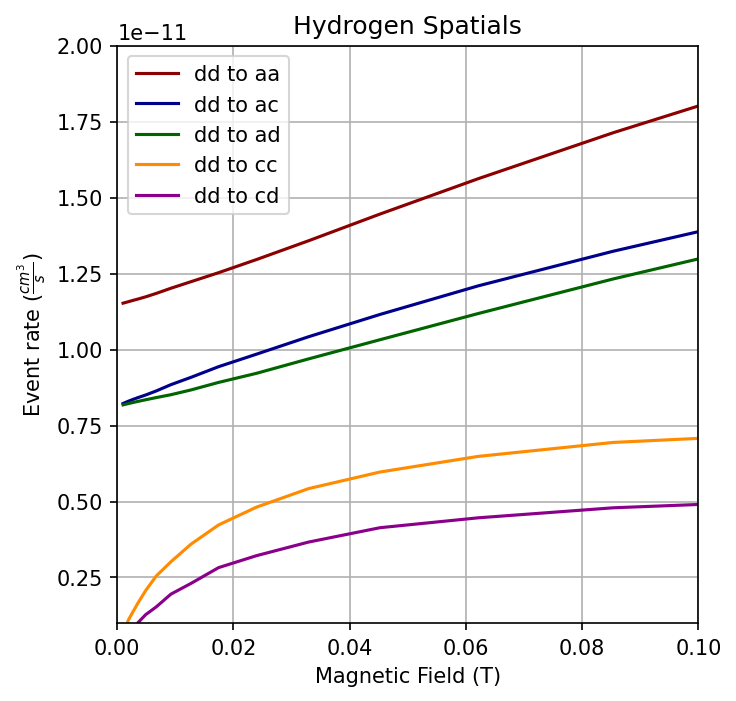

In [43]:
bigrhos = np.linspace(500,2000,5)
for A in bigrhos:
    HaaSpatials = []
    HacSpatials = []
    HadSpatials = []
    HccSpatials = []
    HcdSpatials = []
    TaaSpatials = []
    TacSpatials = []
    TadSpatials = []
    TccSpatials = []
    TcdSpatials = []
    i = 0 
    for b in B:
        aH = HLevels['a'][i] / invB2eV
        cH = HLevels['c'][i] / invB2eV
        dH = HLevels['d'][i] / invB2eV
    
        aT = TLevels['a'][i] / invB2eV
        cT = TLevels['c'][i] / invB2eV
        dT = TLevels['d'][i] / invB2eV

        r0 = 1e-3
        temp = 1e-3
        intlimit = A

        PH = p_of_temp( mH / (2 * kg2au) , temp)
        PT = p_of_temp( mT / (2 * kg2au) , temp)

        PoutHaa = pprime(PH, dH, dH, aH, aH, mH / (2 * kg2au))
        PoutHac = pprime(PH, dH, dH, aH, cH, mH / (2 * kg2au))
        PoutHad = pprime(PH, dH, dH, aH, dH, mH / (2 * kg2au))
        PoutHcc = pprime(PH, dH, dH, cH, cH, mH / (2 * kg2au))
        PoutHcd = pprime(PH, dH, dH, cH, dH, mH / (2 * kg2au))
    
        PoutTaa = pprime(PT, dT, dT, aT, aT, mT / (2 * kg2au))
        PoutTac = pprime(PT, dT, dT, aT, cT, mT / (2 * kg2au))
        PoutTad = pprime(PT, dT, dT, aT, dT, mT / (2 * kg2au))
        PoutTcc = pprime(PT, dT, dT, cT, cT, mT / (2 * kg2au))
        PoutTcd = pprime(PT, dT, dT, cT, dT, mT / (2 * kg2au))  

        IntegralHac = GetIntegral(dH, dH, aH, cH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHad = GetIntegral(dH, dH, aH, dH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHcc = GetIntegral(dH, dH, cH, cH, mH, intlimit, r0, temp, 'DOP853')
        IntegralHcd = GetIntegral(dH, dH, cH, dH, mH, intlimit, r0, temp, 'DOP853')

        IntegralTac = GetIntegral(dT, dT, aT, cT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTad = GetIntegral(dT, dT, aT, dT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTcc = GetIntegral(dT, dT, cT, cT, mT, intlimit, r0, temp, 'DOP853')
        IntegralTcd = GetIntegral(dT, dT, cT, dT, mT, intlimit, r0, temp, 'DOP853')
    
        if b <= 8.5:
            IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'DOP853')
            IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'DOP853')
        
        else:
            IntegralHaa = GetIntegral(dH, dH, aH, aH, mH, intlimit, r0, temp, 'RK45')
            IntegralTaa = GetIntegral(dT, dT, aT, aT, mT, intlimit, r0, temp, 'RK45')
    
        HaaSpatials.append(PoutHaa * mH / (2 * kg2au) * IntegralHaa**2)
        HacSpatials.append(PoutHac * mH / (2 * kg2au) * IntegralHac**2)
        HadSpatials.append(PoutHad * mH / (2 * kg2au) * IntegralHad**2)
        HccSpatials.append(PoutHcc * mH / (2 * kg2au) * IntegralHcc**2)
        HcdSpatials.append(PoutHcd * mH / (2 * kg2au) * IntegralHcd**2)

        TaaSpatials.append(PoutTaa * mT / (2 * kg2au) * IntegralTaa**2)
        TacSpatials.append(PoutTac * mT / (2 * kg2au) * IntegralTac**2)
        TadSpatials.append(PoutTad * mT / (2 * kg2au) * IntegralTad**2)
        TccSpatials.append(PoutTcc * mT / (2 * kg2au) * IntegralTcc**2)
        TcdSpatials.append(PoutTcd * mT / (2 * kg2au) * IntegralTcd**2)

        i = i + 1   
    HaaSpatials = np.array(HaaSpatials) 
    HacSpatials = np.array(HacSpatials) 
    HadSpatials = np.array(HadSpatials) 
    HccSpatials = np.array(HccSpatials) 
    HcdSpatials = np.array(HcdSpatials) 
    TaaSpatials = np.array(TaaSpatials) 
    TacSpatials = np.array(TacSpatials) 
    TadSpatials = np.array(TadSpatials) 
    TccSpatials = np.array(TccSpatials) 
    TcdSpatials = np.array(TcdSpatials) 

    plt.figure(figsize=(5, 5), dpi = 150)
    plt.plot(B, prefactor * HaaSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to aa", color = "DarkRed")
    plt.plot(B, prefactor * HacSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ac", color = "DarkBlue")
    plt.plot(B, prefactor * HadSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to ad", color = "DarkGreen")
    plt.plot(B, prefactor * HccSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cc", color = "DarkOrange")
    plt.plot(B, prefactor * HcdSpatials * Bohr2m**3 * 1e6 / AT2s, label = "dd to cd", color = "DarkMagenta")

    plt.xlabel("Magnetic Field (T)")
    plt.xlim(0,.1)
    plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
    plt.ylim(1e-12,2e-11)
    plt.title("Hydrogen Spatials")
    plt.grid(True)
    plt.legend()
    plt.show()